In [1]:
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import copy as cp

#+____IMPORT FESOM RELATET ROUTINES____________________________________________+
from set_inputarray  import *
from sub_fesom_mesh  import * 
from sub_fesom_mesh  import * 
from sub_fesom_data  import * 
from sub_fesom_plot  import *
from colormap_c2c    import *

In [2]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** LOAD FVSOM MESH ***                             |
#|                                                                             |
#+_____________________________________________________________________________+
# for more options look in set_inputarray.py
inputarray=set_inputarray()
inputarray['save_fig'],inputarray['save_figpath'] = False, '/home/ollie/pscholz/figures/test_pgf/paca98/'

# set plot box for cyl projection (default: [-180,180,-90,90])
#inputarray['which_box'] = [0,360,-90,90] ; inputarray['mesh_focus']=180
inputarray['which_box'],inputarray['proj'] = [-180,180,-90,90], 'cyl'

inputarray['mesh_id'],inputarray['mesh_dir'] = 'COREv2','/work/ollie/pscholz/mesh_fesom2.0/core2_meanz/'
try:
	mesh
except NameError:
    mesh = fesom_init_mesh(inputarray)
    mesh.fesom_calc_nodearea()
    mesh.fesom_calc_landmask()
else:
    if mesh.id!=inputarray['mesh_id']:
        mesh = fesom_init_mesh(inputarray)
        mesh.fesom_calc_nodearea()
        mesh.fesom_calc_landmask()
    else:
        print(' --> ___FOUND {} FESOM MESH --> will use it!___________________________'.format(mesh.id))   


___LOAD FESOM MESH COREv2_________________________________________
 --> read grid files
     > nod2d.out  : #2dn=126858
     > elem2d.out : #2de=244659
     > aux3d.out
     > nlvls.out
     > elvls.out
 --> rotate mesh rot2geo
 --> remove cyclic boundary
_______________________________________________________________
 --> calc. triangle area on nodes m^2 --> calc. triangle area m^2 >> time:0.038 s
 >> time:0.365 s
 --> calc landmask contourline


 --> original cmin,cmax: -1.865881 19.368088
 --> best cmin,cmax: 0.18 17.0
 --> original cmin,cmax: -1.8771518 19.17219
 --> best cmin,cmax: 0.059 17.0


<IPython.core.display.Javascript object>


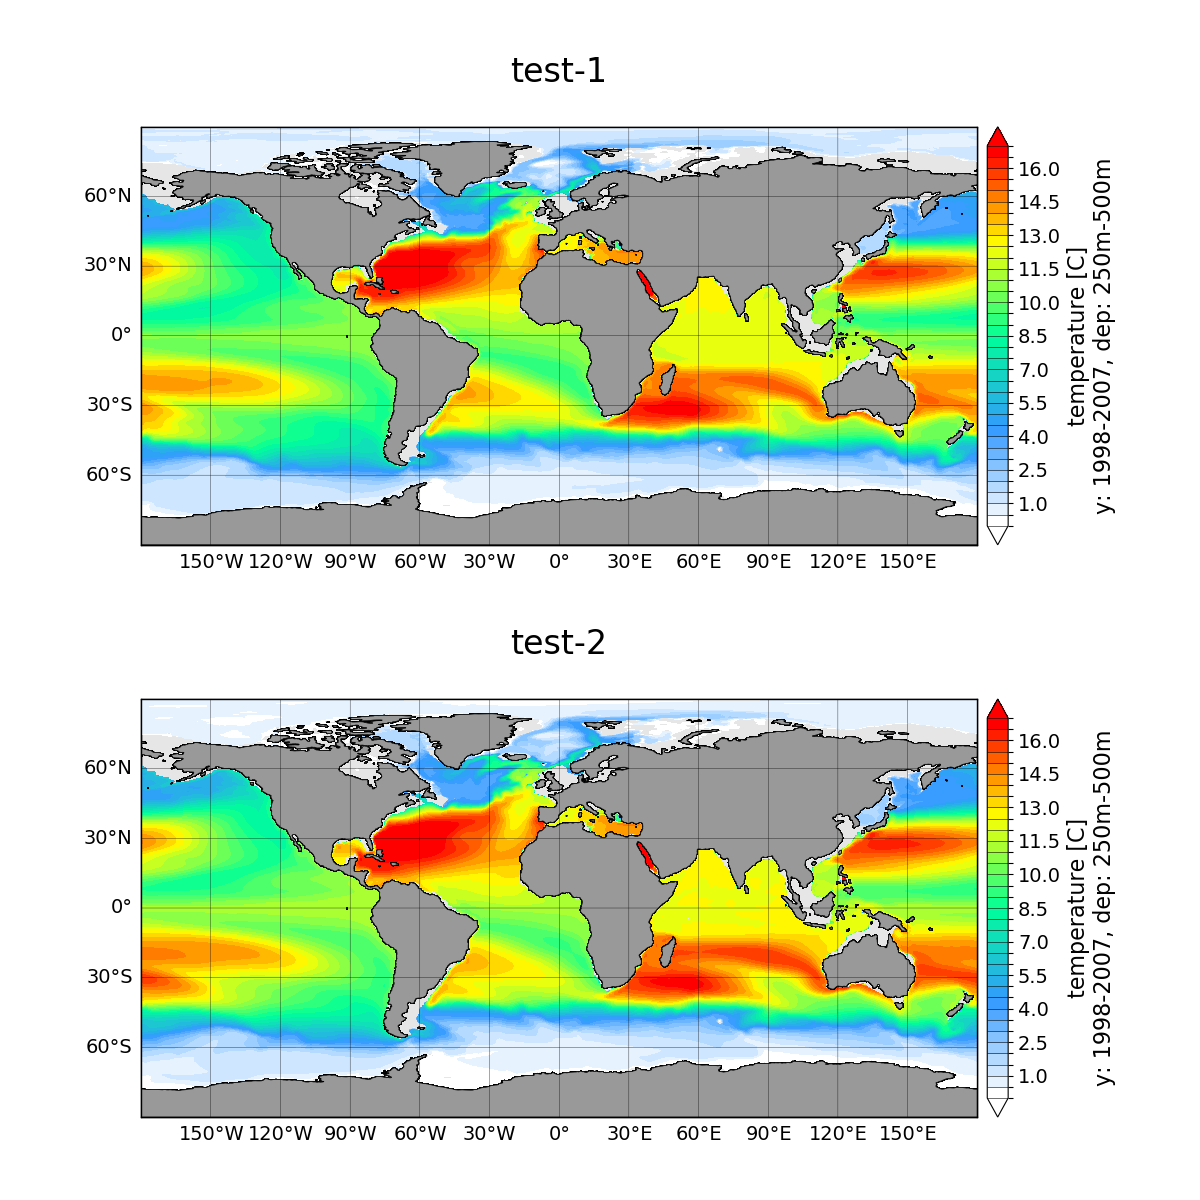

 --> original cmin,cmax: -2.4190197 3.2276735
 --> best cmin,cmax: -1.5 1.1


<IPython.core.display.Javascript object>


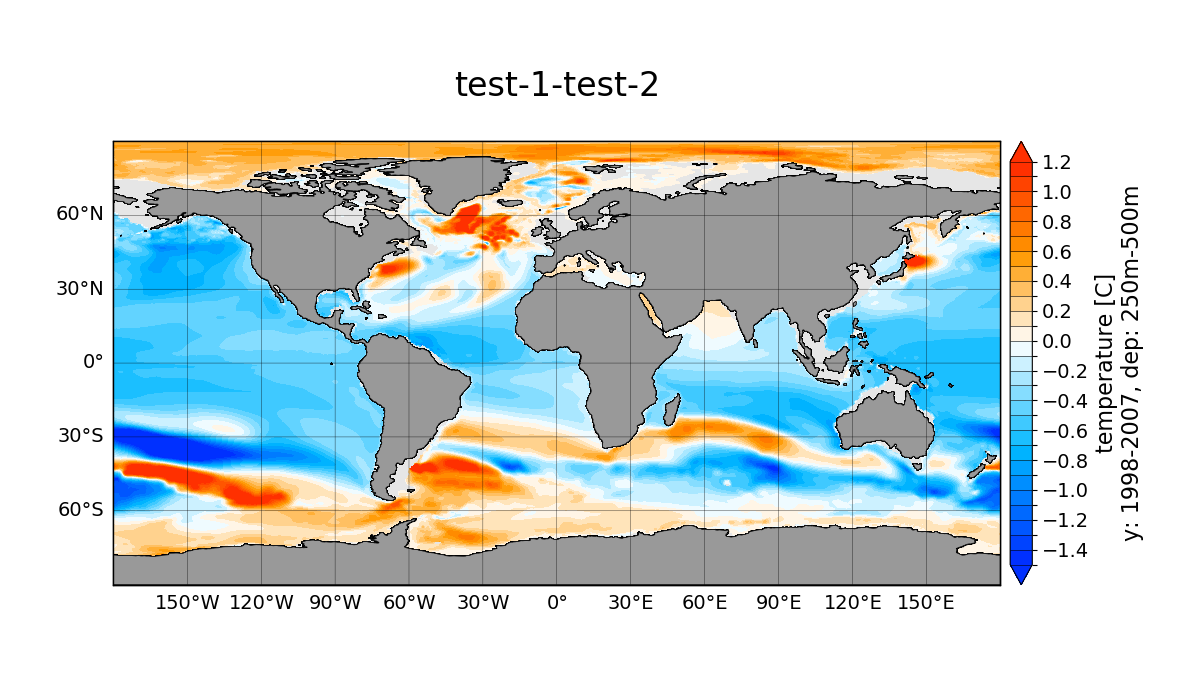

In [8]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** SET INPUT PARAMETER ***                         |
#|                                                                             |
#+_____________________________________________________________________________+
# setup variable name, runid and data path
data 			= fesom_data(inputarray) # init fesom2.0 data object
data.descript,data.path = 'test-1' ,'../results/new_linfs/fesom_kpp/1/'
data.var 		= 'temp'

#+_____________________________________________________________________________+
# select year to average over [start_yr, end_yr]
data.year		= [1998,2007]

# select month to average over
data.month		= [1,2,3,4,5,6,7,8,9,10,11,12]
# data.month		= [9]
# data.record		= [8]

# select linear interpolated depth layers to average over
# data.depth		= [0]
# data.depth		= np.arange(   0, 250+1,10)
data.depth		= np.arange( 250, 500+1,10)
# data.depth	    = np.arange( 500,1000+1,50)
# data.depth	    = np.arange(1000,2000+1,50)
# data.depth	    = np.arange(2000,3000+1,50)

#+_____________________________________________________________________________+
# make anomaly
do_anomaly      = True
if do_anomaly==True:
    data2 			= cp.deepcopy(data) # init fesom2.0 data object
    data2.descript,data2.path = 'test-2' ,'../results/new_linfs/fesom_kpp/3/'
    
#+_____________________________________________________________________________+
#|                       *** LOAD FESOM2.0 DATA ***                            |
#+_____________________________________________________________________________+
fesom_load_data_horiz(mesh,data,do_output='True')    
if data.var.find('MLD')!=-1 : data.value = -data.value;
if data.var=='Kv': data.value, data.lname = np.log10(data.value), 'Vertical diffusivity log10(Kv)'
if data.value.size == mesh.n2dea and data.var.find('vec')==-1: data.value  = mesh.fesom_interp_e2n(np.array(data.value))
if do_anomaly==True:
    fesom_load_data_horiz(mesh,data2,do_output='False')
    if data.var.find('MLD')!=-1 : data2.value = -data2.value
    if data.var=='Kv': data2.value, data2.lname = np.log10(data2.value), 'Vertical diffusivity log10(Kv)'
    if data2.value.size == mesh.n2dea and data.var.find('vec')==-1: data2.value = mesh.fesom_interp_e2n(np.array(data2.value))
    if data.var.find('vec')==-1 : 
        anom = fesom_data_anom(data2,data)
        if anom.value.size == mesh.n2dea: anom.value  = mesh.fesom_interp_e2n(np.array(anom.value))

#+_____________________________________________________________________________+
#|                       *** PLOT FESOM2,0 DATA ***                            |
#+_____________________________________________________________________________+
# plot 2d and 2dvec data
if len(data.value2)==0:
    #_______________________________________________________________________
    idx_box = fesom_idxinbox(mesh,data,inputarray)
    
    #___________________________________________________________________________
    # plot anomaly
    if do_anomaly==False:
        fac = 1.0
        cmin,cmax = fesom_choose_best_crange(data.value[idx_box]*fac, mesh.nodes_2d_area[idx_box], 0.99)
        #_______________________________________________________________________
        data.cmap,data.cnumb = 'wbgyr',20
        if data.var=='salt':cmin=30.0
        if data.var=='Kv': data.cmap,cmin,cmax='wbgyr',-6.0 ,1
        cref = cmin + (cmax-cmin)/2
        cref = np.around(cref, -np.int32(np.floor(np.log10(np.abs(cref)))-1) ) 
        if data.var=='ssh' or data.var=='hw' or data.var=='fw' or data.var =='w':cref=0.0
        data.crange = [cmin,cmax,cref]
        #_______________________________________________________________________
        fig,ax,map,cbar,hp1,tri=fesom_plot2d_data(mesh,data,figsize=[12,7],do_grid=False)
    else:
        #_______________________________________________________________________
        fac =1.0
        cmin,cmax   = fesom_choose_best_crange(data.value[idx_box]*fac, mesh.nodes_2d_area[idx_box], 0.99)
        cmin1,cmax1 = fesom_choose_best_crange(data2.value[idx_box]*fac, mesh.nodes_2d_area[idx_box], 0.99)
        cmin,cmax   = np.min([cmin,cmin1]), np.max([cmax,cmax1])
        #_______________________________________________________________________
        data.cmap, data2.cmap, data.cnumb, data2.cnumb  = 'wbgyr','wbgyr', 20, 20
        if data.var=='salt':cmin=32.0
        if data.var=='Kv': data.cmap,data2.cmap,cmin,cmax='wbgyr','wbgyr',-6.0 ,1
        cref = cmin + (cmax-cmin)/2
        cref = np.around(cref, -np.int32(np.floor(np.log10(np.abs(cref)))-1) ) 
        if data.var=='ssh' or data.var=='hw' or data.var=='fw' or data.var =='w':cref=0.0
        if data.var =='w': cmin,cmax,cref=cmin*0.01,cmax*0.01,0.0
        data.crange,data2.crange = [cmin,cmax,cref],[cmin,cmax,cref]	
        #_______________________________________________________________________
        fig, (ax1, ax2) = plt.subplots(2,1, figsize=[12,12])
        fig,ax1,map,cbar ,hp1,tri=fesom_plot2d_data(mesh,data ,do_subplot=[fig,ax1],do_grid=False,do_output=False)
        fig,ax2,map,cbar2,hp2,tri=fesom_plot2d_data(mesh,data2,do_subplot=[fig,ax2],do_grid=False,do_output=False)
        fig.tight_layout(pad=4)
        fig.canvas.draw()   
        
        #_______________________________________________________________________
        fac = 1.0
        cmin,cmax = fesom_choose_best_crange(anom.value[idx_box]*fac, mesh.nodes_2d_area[idx_box], 0.99)
        #_______________________________________________________________________
        cref      = 0.0
        anom.crange, anom.cnumb, anom.cmap = [cmin,cmax,cref], 20, 'blue2red'
        # if data.var=='temp': anom.crange= [-4.0,4.0, 0.0]
        # if data.var=='salt': anom.crange= [-0.5,0.5, 0.0]
        #_______________________________________________________________________    
        fig,ax,map,cbar,hp1,tri=fesom_plot2d_data(mesh,anom,figsize=[12,7],do_output=False)
        fig.tight_layout(pad=4)
        fig.canvas.draw()
else:
    if do_anomaly==False:
        fac = 1.0
        norm1 = np.sqrt(data.value**2+data.value2**2)
        cmin,cmax = 0.0, np.max([np.nanmax(norm1)])*fac
        cmax = np.around(cmax, -np.int32(np.floor(np.log10(np.abs(cmax)))-0) ) 
        cref = cmin + (cmax-cmin)/2
        cref = np.around(cref, -np.int32(np.floor(np.log10(np.abs(cref)))-1) ) 
        data.crange = [cmin,cmax,cref]
        data.cnumb=20
        print(cmin,cmax,cref)
        fig,ax1,cbar1,hp1=fesom_plot2dvec_data(mesh,data,figsize=[12,12],do_output=False)
    else:
        fac = 0.1
        norm1,norm2 = np.sqrt(data.value**2+data.value2**2),np.sqrt(data2.value**2+data2.value2**2)
        cmin,cmax = 0.0, np.max([np.nanmax(norm1),np.nanmax(norm2)])*fac
        cmax = np.around(cmax, -np.int32(np.floor(np.log10(np.abs(cmax)))) ) 
        cref = cmin + (cmax-cmin)/2
        cref = np.around(cref, -np.int32(np.floor(np.log10(np.abs(cref)))-1) ) 
        data.crange,data2.crange = [cmin,cmax,cref], [cmin,cmax,cref]
        data.cnumb, data2.cnumb  = 20 , 20
        print(cmin,cmax,cref)
        fig, (ax1, ax2) = plt.subplots(2,1, figsize=[12,12])
        dumfig,ax1,cbar1,hp1=fesom_plot2dvec_data(mesh,data ,do_subplot=[fig,ax1],do_output=False)
        dumfig,ax2,cbar2,hp2=fesom_plot2dvec_data(mesh,data2,do_subplot=[fig,ax2],do_output=False)
        fig.tight_layout(pad=4)
        fig.canvas.draw()  
        fig.show()